In [11]:
%cd /home/heydar/me/BSC/FinalPorject/lsh

/home/heydar/me/BSC/FinalPorject/lsh


In [12]:
import numpy as np
from time import time

# Loading Dataset
## Preparing Dataset from sickit-learn
In this example our dataset is a news group dataset.

In [13]:
from sklearn.datasets import fetch_20newsgroups
#Load dataset
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)
labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)

### Do TF-IDF on dataset

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)

In [15]:
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 2.306 s


after adding limit to data some of rows are empty so we need to drop them for better result.

In [16]:
drops_datas=np.where([X_tfidf.getnnz(1)<1])[1]
nnzero_rows=X_tfidf.getnnz(1)>1
labels=labels[nnzero_rows]
X_tfidf=X_tfidf[nnzero_rows]

In [17]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")
shingles = [set(vector[0].nonzero()[1]) for vector in X_tfidf]

0.007


In [18]:
# Create a copy of the CSR matrix and convert it to a COO matrix
coo_matrix = X_tfidf.tocoo(copy=True)

# Replace non-zero values with their own column indices
coo_matrix.data = coo_matrix.col

# Convert the COO matrix back to CSR format
shingles = coo_matrix.tocsr()


In [19]:
#set Cluster Number
true_k = 500


In [20]:
X_tfidf.shape[1]

7929

In [21]:

from src.LSH.MinHash import MinHash
from src.LSH.lsh import LSH
#Make LSH
prime=8017
lsh_time_start=time()
b, r = 1, 1
num_perm = b * r
minhash = MinHash(num_perm)
mh = minhash.sign_csr_callback_permutation(shingles, shingles.shape[1],prime)
mh = np.array(mh)
print('waiting for Create LSH index')
# Create LSH index
lsh = LSH(b=b, r=r)
lsh.fit(mh)
print('LSH index Created')
lsh_time=time()-lsh_time_start

waiting for Create LSH index
LSH index Created


In [22]:
from collections import defaultdict
from sklearn import metrics
evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X,lsh=None, name=None, n_runs=5,seek_time=0):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.random_state=seed
        t0 = time()
        if lsh:
            km.fit(X,lsh)
        else:
            km.fit(X)
        train_times.append(time()+seek_time - t0)
        scores['inertia'].append(km.inertia_)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)


In [48]:
#Doing Fast Kmeans++
from sklearn.cluster import KMeans
skmeans=KMeans(n_clusters=true_k,max_iter=1,n_init=1).fit(X_tfidf)


In [42]:
from src.Kmeans.mh_kmeans import MHKmeans

mh_kmeas=MHKmeans(
    n_clusters=true_k,
    max_iteration=30,
    n_init=1,
    verbose=True,
    
    init=skmeans.cluster_centers_
)
fit_and_evaluate(mh_kmeas, X_tfidf,lsh, name="Mh KMeans++ \non  tf-idf vectors", n_runs=5)


Init: initializing centers
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/30, moves: 83, cost: [3113.65736841] in 5.355414867401123 seconds
Run 1, iteration: 2/30, moves: 28, cost: [3109.69658878] in 4.681729078292847 seconds
Run 1, iteration: 3/30, moves: 10, cost: [3108.82709229] in 4.991217613220215 seconds
Run 1, iteration: 4/30, moves: 7, cost: [3108.39751122] in 4.5709547996521 seconds
Run 1, iteration: 5/30, moves: 2, cost: [3107.9184377] in 4.814739942550659 seconds
Run 1, iteration: 6/30, moves: 0, cost: [3107.87655044] in 4.88943076133728 seconds
Run 1, iteration: 7/30, moves: 125, cost: [3105.83039382] in 14.688839673995972 seconds
Run 1, iteration: 8/30, moves: 44, cost: [3101.41651165] in 4.723452806472778 seconds
Run 1, iteration: 9/30, moves: 26, cost: [3099.96496334] in 4.77278470993042 seconds
Run 1, iteration: 10/30, moves: 11, cost: [3099.07693703] in 4.67717719078064 seconds
Run 1, iteration: 11/30, moves: 5, cost: [3098.65763582] in 4.723344

Run 1, iteration: 3/30, moves: 14, cost: [3108.05799466] in 12.432545185089111 seconds
Run 1, iteration: 4/30, moves: 6, cost: [3107.5169644] in 11.86666226387024 seconds
Run 1, iteration: 5/30, moves: 2, cost: [3107.38520415] in 11.292482852935791 seconds
Run 1, iteration: 6/30, moves: 1, cost: [3107.33802719] in 6.727179527282715 seconds
Run 1, iteration: 7/30, moves: 0, cost: [3107.32084198] in 8.580362319946289 seconds
Run 1, iteration: 8/30, moves: 124, cost: [3105.42987015] in 31.56016707420349 seconds
Run 1, iteration: 9/30, moves: 40, cost: [3101.06886151] in 12.338690280914307 seconds
Run 1, iteration: 10/30, moves: 23, cost: [3099.73461367] in 11.7288498878479 seconds
Run 1, iteration: 11/30, moves: 15, cost: [3098.92641031] in 12.0263512134552 seconds
Run 1, iteration: 12/30, moves: 5, cost: [3098.44997793] in 11.86854076385498 seconds
Run 1, iteration: 13/30, moves: 1, cost: [3098.3561461] in 4.662065267562866 seconds
Run 1, iteration: 14/30, moves: 0, cost: [3098.32885936]

In [9]:
from src.Kmeans.kmeans import Kmeans


In [23]:
simple_kmeans = Kmeans(
    n_clusters=true_k,
    max_iteration=30,
    n_init=1,
    verbose=True,
    
    init='kmeans++'
)

fit_and_evaluate(simple_kmeans, X_tfidf,None, name="KMeans random \non  tf-idf vectors", n_runs=5)


Init: initializing centers


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/heydar/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_20507/260938349.py", line 10, in <module>
    fit_and_evaluate(simple_kmeans, X_tfidf,None, name="KMeans random \non  tf-idf vectors", n_runs=5)
  File "/tmp/ipykernel_20507/3734144126.py", line 18, in fit_and_evaluate
    km.fit(X)
  File "/home/heydar/me/BSC/FinalPorject/lsh/src/Kmeans/kmeans.py", line 470, in fit
    centroids = self._init_centroids(
  File "/home/heydar/me/BSC/FinalPorject/lsh/src/Kmeans/kmeans.py", line 569, in _init_centroids
    centroids= _kmeans_plusplus(
  File "/home/heydar/me/BSC/FinalPorject/lsh/src/Kmeans/kmeans.py", line 64, in _kmeans_plusplus
    _diss = fdissimilarity(centroids[:k_selected, :], curpoint)
  File "/home/heydar/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py", line 330, in euclidean_distances
    retu

TypeError: object of type 'NoneType' has no len()

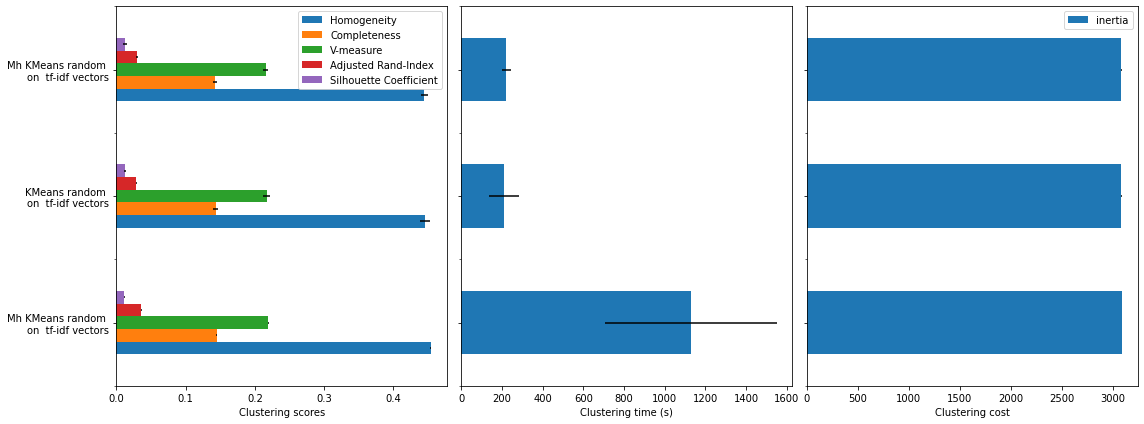

In [44]:


# Plot
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax0, ax1,ax2) = plt.subplots(ncols=3, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time",'inertia'],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")


df[['inertia']].plot.barh(ax=ax2,xerr=df_std)
ax2.set_xlabel("Clustering cost")
ax2.set_ylabel("")


plt.tight_layout()
plt.show()

